<a href="https://colab.research.google.com/github/Julius-Mwakichi/Hello-world/blob/main/Reinforcement_Learning_for_Biginners.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **üèîÔ∏èFrozen Lake: An Icy Adventure using Reinforcement Learning! üèîÔ∏è**

<img src="https://drive.google.com/uc?export=view&id=17Pj6ZVnL9VM7bwMZhHM7EuFIxnf2lv3O" width="60%" />


<a href="https://colab.research.google.com/github/deep-learning-indaba/indaba-pracs-2023/blob/main/practicals/RL_2023_prac.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

¬© Deep Learning Indaba 2023. Apache License 2.0.

**Authors:** Kale-ab Tessera, Ruan de Kock and Omayma Mahjoub.

**Reviewers:** Kevin Eloff, Ulrich Mbou Sob, Siddarth Singh, Ruan van der Merwe, Marianne Monteiro

**Introduction:**

In this tutorial, we will be learning about Reinforcement Learning, a type of Machine Learning where an agent learns what to do (i.e. map situations to actions) by interacting with an environment, while trying to maximize a reward signal that tells us how good or bad our current environment configuration is.

RL has seen tremendous success in a wide range of challenging domains such as learning to play complex games like [Atari](https://arxiv.org/abs/1312.5602), [StarCraft II](https://www.nature.com/articles/s41586-019-1724-z) and [GO](https://www.nature.com/articles/nature16961), and applications like [robotics](https://arxiv.org/abs/1808.00177). Modern natural language processing (NLP) also uses RL to improve the quality of language models based on human feedback (see [RLHF](https://huggingface.co/blog/rlhf)).  

In this tutorial, we will show how RL can be used to help our agent cross a Frozen Lake, while avoiding perilous holes in the ice in order to get to a goal. You will use several different RL approaches, ranging from tabular Q-learning to more modern methods, such as [DQN (Deep Q-Networks)](https://arxiv.org/abs/1312.5602). Along the way, you will be introduced to some of the most fundamental concepts and terminology in RL, while trying to build intuition into what RL is about.


**Topics:**

Content: Reinforcement Learning

Level:  <font color='blue'>`Beginner`</font>


**Aims/Learning Objectives:**

*   [<font color='blue'>`Beginner`</font>] Understand the basic theory, terminology and intuition behind RL.
*   [<font color='blue'>`Beginner`</font>]
 Introduced to some different ways of learning in RL.
*   [<font color='orange'>`Intermediate`</font>] Implement a simple Q-learning agent.
*   [<font color='green'>`Advanced`</font>] Introduced to Deep RL methods - such as DQN.

**Prerequisites:**

* Some familiarity with [JAX](https://github.com/google/jax).
* Neural network basics.



**Outline:**

**Before you start:**

For this practical, you will need to use a GPU to speed up training. To do this, go to the "Runtime" menu in Colab, select "Change runtime type" and then in the popup menu, choose "GPU" in the "Hardware accelerator" box.

**Suggested experience level in this topic:**

| Level         | Experience                            |
| --- | --- |
`Beginner`      | It is my first time being introduced to this work. |
`Intermediate`  | I have done some basic courses/intros on this topic. |
`Advanced`      | I work in this area/topic daily. |

## Installation and Imports

In [ ]:
## Install and import anything required. Capture hides the output from the cell.
# @title Install and import required packages. (Run Cell)
%%capture
!pip install gymnasium

# For replay buffer
!pip install stable_baselines3

import jax
import jax.numpy as jnp
from jax import grad, jit, vmap

import gymnasium as gym

import matplotlib.pyplot as plt
import numpy as np
import imageio
from IPython.display import display, Image
import io

from tqdm import notebook

In [ ]:
# @title Helper Functions. (Run Cell)

def display_state_values_as_gif(array_list, duration=500):
    """
    Display a list of 4x4 numpy arrays as a GIF of heatmaps in IPython.

    Parameters:
    - array_list: List of 4x4 numpy arrays.
    - duration: Duration each frame lasts in the GIF (in milliseconds).
    """

    # Create a list to store PNG images
    images = []

    for arr in array_list:
        fig, ax = plt.subplots(figsize=(4, 4))
        im = ax.imshow(arr, cmap='viridis', interpolation='nearest')

        # Display values in the cells
        for i in range(arr.shape[0]):
            for j in range(arr.shape[1]):
                ax.text(j, i, format(arr[i, j], '.2f'),
                        ha='center', va='center', color='white', fontsize=8)

        ax.axis('off')  # Turn off axis numbers and ticks
        fig.tight_layout(pad=0)  # This will remove extra whitespaces

        # Convert the Matplotlib plot to a PIL Image
        buf = io.BytesIO()
        plt.savefig(buf, format='png', bbox_inches='tight', pad_inches=0)
        buf.seek(0)
        images.append(imageio.v2.imread(buf))
        plt.close()

    # Convert list of images into a GIF in memory
    buf = io.BytesIO()
    imageio.mimsave(buf, images, format='GIF', duration=duration, loop=0)
    buf.seek(0)

    # Display GIF in IPython
    display(Image(data=buf.getvalue(), format='png'));

def plot_cell(ax, i, j, values, cmap, norm):
    size = 1  # Size of each cell
    x = j  # Swap the x-coordinate with j
    y = 3-i  # Swap the y-coordinate with i and adjust for plotting

    # Draw box around the square cell
    ax.plot([x, x], [y, y + size], color='k')  # Left vertical line
    ax.plot([x + size, x + size], [y, y + size], color='k')  # Right vertical line
    ax.plot([x, x + size], [y, y], color='k')  # Bottom horizontal line
    ax.plot([x, x + size], [y + size, y + size], color='k')  # Top horizontal line

    # Fill each section with the heatmap color and adjust the position of values
    for i, val in enumerate(values):
        color = cmap(norm(val))
        if i == 0:  # Left-most section
            ax.fill([x, x, x + 0.5], [y, y + 1, y + 0.5], color=color)
            ax.text(x + 0.25, y + 0.5, format(val, '.2f'), ha='center', va='center', color='white', fontsize=8)
        elif i == 1:  # Bottom-most section
            ax.fill([x, x + 1., x + 0.5], [y, y, y + 0.5], color=color)
            ax.text(x + 0.5, y + 0.25, format(val, '.2f'), ha='center', va='center', color='white', fontsize=8)
        elif i == 2:  # Right-most section
            ax.fill([x+1, x + 1., x + 0.5], [y, y+1, y + 0.5], color=color)
            ax.text(x + 0.75, y + 0.5, format(val, '.2f'), ha='center', va='center', color='white', fontsize=8)
        else:  # Top-most section
            ax.fill([x, x + 1., x + 0.5], [y+1, y+1, y + 0.5], color=color)
            ax.text(x + 0.5, y + 0.75, format(val, '.2f'), ha='center', va='center', color='white', fontsize=8)

def display_q_values_as_gif(array_list, duration=500):
    images = []

    # Create a colormap and a normalization based on global min and max values
    global_min = np.min(array_list)
    global_max = np.max(array_list)
    cmap = plt.get_cmap('viridis')
    norm = plt.Normalize(global_min, global_max)

    for arr in array_list:
        fig, ax = plt.subplots(figsize=(5, 5))

        for i in range(4):
            for j in range(4):
                plot_cell(ax, i, j, arr[i, j], cmap, norm)

        ax.set_xlim(0, 4)
        ax.set_ylim(0, 4)
        ax.axis('off')

        # Convert the Matplotlib plot to a PIL Image
        buf = io.BytesIO()
        plt.savefig(buf, format='png', bbox_inches='tight', pad_inches=0)
        buf.seek(0)
        images.append(imageio.v2.imread(buf))
        plt.close()

    # Convert list of images into a GIF in memory
    buf = io.BytesIO()
    imageio.mimsave(buf, images, format='GIF', duration=duration, loop=0)
    buf.seek(0)

    # Display GIF in IPython
    display(Image(data=buf.getvalue(), format='png'))

def print_q_table(q_table, name_actions=False):
    # Get the number of states and actions
    num_states = len(q_table)
    num_actions = len(q_table[0]) if num_states > 0 else 0

    # Calculate maximum width required for states and action headers for alignment
    max_state_width = len(f"s_{num_states-1} |")
    max_action_width = max(max([len(f"{value:.4f}") for row in q_table for value in row]), len(f"a_{num_actions-1}"))

    # Column headers
    if name_actions:
      action_names = ["Left", "Down", "Right", "Up"]
      headers = [" ".rjust(max_state_width)] + [action.rjust(max_action_width) for action in action_names]
    else:
      headers = [" ".rjust(max_state_width)] + [f"a_{j}".rjust(max_action_width) for j in range(num_actions)]

    # Calculate the line below headers to span the full width
    line_below_headers = "-" * (max_state_width + max_action_width * num_actions + (num_actions - 1) * 3 + 3)
    # Convert the matrix data to formatted strings
    rows = []
    for i, row in enumerate(q_table):
        formatted_row = [f"s_{i} |".rjust(max_state_width)] + [f"{value:.4f}".rjust(max_action_width) for value in row]
        rows.append("   ".join(formatted_row))

    # Combine everything
    full_table = "\n".join(["   ".join(headers), line_below_headers] + rows)
    print(full_table)

## **0. Overview of Reinforcement Learning** - <font color='blue'>`Beginner`</font>

Reinforcement Learning (RL) is a type of Machine Learning (ML), where the goal is to learn **what to do** in a specific scenario. Unlike other forms of ML, such as supervised learning, we don't have labelled examples of expected behaviour, but rather we learn from interactions.

**Exercise 0.1 (Group Discussion Task):  Why learn without labelled data?**

Discuss with your neighbours why you would want to possibly learn without labelled data. Practical scenarios might help this discussion, let's say you wanted to create a robot that plays a game such as chess, how would you generate labelled data in this case?  

<img src="https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQ9u3R54L7cjuiG-TxLl8MNFeiIs_Q1dUtHqg&usqp=CAU"/>



#### Possible talking points and takeaways from group discussion (Try not to peek until you've given it a good try!')

**Why learn without labelled data?**

* Learning with labelled data can be **challenging** as you would need an "expert" to help create a dataset. In certain domains, this data might be expensive or difficult to collect (e.g. Robotics). Furthermore, it is challenging to ensure this data is representative of the behaviours you would like to learn. In the chess example, you would need to create a dataset of expert chess games.
* If we train a model on a dataset of behaviour, this model will simply learn to **imitate** what is seen in the dataset, and wouldn't outperform the expert from which the examples were collected.    



### **0.1 Intuition & RL Flow - <font color='blue'>`Beginner`</font>**

How can we learn intelligent behaviour without labels you might ask? We need to introduce some concepts, such as -- **agents** ü§ñ, **environments** üå¥, <font color='blue'>actions</font>,  <font color='orange'>observations</font>  and <font color='green'>rewards</font> --  before we can explain this.



**Agents ü§ñ and Environments üå¥**

In RL, we have two main entities - Agents and an Environment.

* **Agent ü§ñ:** An *agent* is the *decision-maker* in an RL. Broadly, it is an entity that interacts with an environment, makes **decisions** (known as <font color='blue'>actions</font>), adapts and **learns**.

  > Note that an agent in RL could refer to a virtual agent, such as an AI model, or a physical agent, such as a robot. For this practical, our focus is on virtual AI agents.


* **Environment üå¥:** An environment is the problem we care about solving. This returns a signal known as the <font color='green'>rewards</font>, which tells us how good our current situation is (e.g. a score in a game) and returns  <font color='orange'>observations</font>, which is a representation of the world from the agent's perspective. This environment changes when agents act on it, but also could change on its' own.  


The goal of our RL agent is to take actions in a way to maximize the reward (score) over time.


**RL Interaction Flow** üåÄ

Let's consider the same example from **Exercise 0.1**, where we have an agent that is learning how to play chess.

Our agent receives a view of the current chessboard -- known as an  <font color='orange'>observation</font> ($o_t$). This observation is used by our agent to decide what  <font color='blue'>action</font> ($a_t$) to take -- such as moving one of the pieces. Based on the action our agent took and the observation of the environment/chessboard, our agent receives a <font color='green'>reward</font> ($r_t$), this could be a positive reward for capturing a piece or a negative reward for losing a piece.

> the $_t$ simply refers to the property of a value at a timestep. For example, `a_0` is the action at timestep `0`.


Here is a diagram of this flow.

![RL Interaction Loop](https://drive.google.com/uc?export=view&id=1NXcDX_CgWqHuegs7pKfGKxm-wOPuY0RL)

**Sequential Decision Making**

Something that is critical to RL is this notion of **sequential** decision making. Although the flow above might look like our agent is making a single decision, this diagram only represents a single step. Our agent actually makes multiple decisions over time (grouped as timesteps) as we can see below:

![RL Sequential Flow](https://drive.google.com/uc?export=view&id=1qX0wd8k0ERBCGc5y7KLGlyxyB9dvENiu)


We also group interactions into **episodes**, which are the interactions of our agent and environment from the beginning to the end (you will learn more about how we define the "end" of our agent-environment interactions in section 1.2 Environment (**Terminal State**).

**Group Task:**

**Exercise 0.2 (Group Discussion Task): Differences between RL and Supervised Learning Tasks**

Discuss with your neighbours how RL is different from Supervised Learning. You can mention things like how these forms of ML make decisions, what data you feel you would use to train these systems, how you think these systems could learn and what are their objectives.

#### Possible talking points and takeaways from group discussion (Try not to peek until you've given it a good try!')

**Differences between RL and Supervised Learning (SL) Tasks**

*   **Kinds of Decisions** - In RL decisions are sequential, i.e. you make multiple decisions over time, while in SL, decisions are often one-shot e.g. you decide once if an image is a cat or a dog.

  > Note that sometimes Natural language processing (NLP) or Time-series prediction tasks are sequential, e.g. using [autoregressive models](https://en.wikipedia.org/wiki/Autoregressive_model) like [GPT](https://arxiv.org/abs/2005.14165) to predict the next token (see [LLM prac](https://github.com/deep-learning-indaba/indaba-pracs-2023/blob/main/practicals/LLM_prac.ipynb)). In this scenario, the main difference is the lack of a training dataset in RL and how these systems learn.


*   **Training Data** - In RL, you typically don't have a training dataset of expert behaviour (an exception to this is [Offline RL](https://huggingface.co/learn/deep-rl-course/unitbonus3/offline-online)), but rather you have an environment with a reward system that defines what is good or bad. In SL, you have a labelled dataset with the desired behaviour.
*   **Learning** - In RL, you learn from interacting with the environment through trial-and-error, while in SL, you learn from the training data directly. More information on learning in RL will be provided in **Section 2**.
*   **Objectives** - In RL, your objective is to maximize reward over time, while in SL, you want to generalize from the training data to unseen data.  


### **0.2 Become your own RL agent! - <font color='blue'>`Beginner`</font>**

Before we give any more context about reinforcement learning, let's experience reinforcement learning from the perspective of the agent!

You will play the role of an agent who is trying to learn how to solve some task.
* You will take <font color='blue'>actions</font> using your keyboard -- you can go up, down, left or right by inputting "w", "a", "s" or "d".
* You will then see how the game evolves by looking at the new  <font color='orange'>observation</font> provided by the map.
* You will also get a <font color='green'>reward</font> value for each step telling you how good your previous decision was.  

Sounds interesting? Let's go! üöÄ

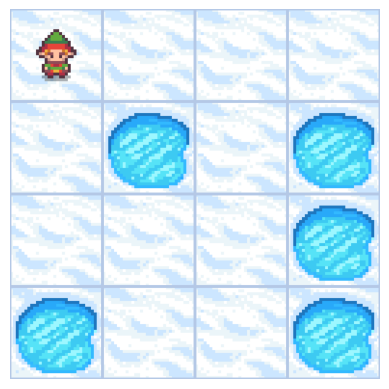

In [ ]:
import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output

# Create the FrozenLake environment with render_mode for RGB output
env = gym.make('FrozenLake-v1', map_name='4x4', is_slippery=False, render_mode="rgb_array")

# Map keyboard input to actions
action_map = {
    'w': 3,  # up
    'a': 0,  # left
    's': 1,  # down
    'd': 2,  # right
}

# Function to render and display the environment
def display_env(reward):
    clear_output(wait=True)
    frame = env.render()
    img = np.array(frame)

    if reward != 1.0:
        img[192:, 192:] = img[64:128, 64:128]

    plt.imshow(img)
    plt.axis('off')
    plt.show()

# Start the game
obs, info = env.reset()
display_env(0.0)
done = False

# Game loop
while not done:
    action_key = input("Enter action (w: up, a: left, s: down, d: right, q: quit): ").lower()

    if action_key == 'q':
        print("Game exited.")
        break

    if action_key not in action_map:
        print("Invalid input. Use w/a/s/d.")
        continue

    action = action_map[action_key]
    obs, reward, terminated, truncated, info = env.step(action)
    done = terminated or truncated

    display_env(reward)
    print(f"Reward: {reward}")

    if done:
        if reward == 1.0:
            print("üéâ You reached the goal! Great job!")
        else:
            print("üíÄ You fell into a hole. Try again!")



#### Click Here if you need a hint!

There are **5** holes üßä in the ice and **1** of them is a fake hole and contains your goalüéÅ. Can you try and find it?

#### Trial and Error

Did you reach the goal üéÅ on your first try or did you have to do a few rounds of trial-and-error? RL agents follow a similar process of trial-and-error when trying to maximize their rewards. Furthermore, similarly to an agent you learnt what to do in different situations based on the reward signal the environment gave you.  

It is likely that if you saw the goal üéÅ on the map, you would simply avoid the holes üßä and go straight to the goal üéÅ. This intuition (holes -> bad, üéÅ -> good) is something that RL agents have to learn through interaction and not from any training dataset.

#### **Summary**:

RL is goal-directed learning from interaction (trial and error). Our agents learn *what to do* (how to map situations to actions), so as to maximize a numerical reward.

## **1. Formalizing an RL Problem**  - <font color='blue'>`Beginner`</font> & <font color='orange'>`Intermediate`</font>

In the previous section, we tried to give the intuition behind RL. In this section, we will formally define our RL problem - both from the perspective of the environment and our agent.

### 1.1 Environment - <font color='blue'>`Beginner`</font>

As mentioned in the previous section, an environment is the problem/system that we care about, and that receives <font color='blue'>actions</font> and provides the <font color='orange'>observation</font> and <font color='green'>rewards</font>.




#### üèîÔ∏èIntroducing our Environment - FrozenLake üèîÔ∏è

[Frozen lake](https://gymnasium.farama.org/environments/toy_text/frozen_lake/) is an RL environment, where the goal is to cross a frozen lake, from a start position to a goal position, without falling into any holes. Some parts of the lake might also be slippery, making movement difficult.

![frozen_lake.gif](https://www.gymlibrary.dev/_images/frozen_lake.gif)

#### <font color='orange'>States</font> and <font color='orange'>Observations</font> - $s_t$ and $o_t$ - <font color='blue'>`Beginner`</font>

In RL, an agent perceives an <font color='orange'>observation</font> of the environment's state. You can think of this as a view of the environment from an agent's perspective.  

In some settings, this view may include all the information underlying the environment's state. Such an environment is called *fully observed*. In other settings, the agent may only receive *partial information* about the environment's state in its observation. Such an environment is called *partially observed*.


For the rest of this tutorial, we will assume the environment is fully observed and so we will use <font color='orange'>state</font> $s_t$ and <font color='orange'>observation</font> $o_t$ interchangeably.

##### Example of Partially Observed and Fully-observed environment Environments

* *Partially observed environment* - An environment where an agent can only see within a specific range around them:

  <img src="https://drive.google.com/uc?export=view&id=19wJXHaoCrgGZj_eClNychKDx_3_MjH6X" width="40%" />

* *Fully-observed environment* - An environment where the agent can see a view of the whole environment state:

  <img src="https://drive.google.com/uc?export=view&id=1QutFY-pX5LcLhWWOAFqaIzjBNwM-EdYf" width="40%"/>



##### Let's initialize our environment and see what the initial state looks like:

OpenAI has provided a Python package called **Gym** that includes implementations of popular environments and a simple interface for an RL agent to interact with. To use a supported [gym environment](https://www.gymlibrary.dev/index.html), all you need to do is pass the name of the environment to the function `gym.make(<environment_name>)`.

Let's create our FrozenLake environment.

In [ ]:
# create the environment
env=gym.make('FrozenLake-v1', desc=None, map_name="4x4", is_slippery=False, render_mode="ansi")

# Get the initial state by resetting the env
s_0, info= env.reset(seed=42)

Print out our initial state and state space:

In [ ]:
print(f"Initial State: {s_0}")

obs_space = env.observation_space
print("Environment Obs Space:", obs_space)

In Frozen Lake, the state value (`0` in the print out above) represents the player‚Äôs current position in a flattened version of the map. For example, since we are using a `4x4` version of the map, we have 16 grids, and our agent starts at grid 0.

The observation space corresponds to the number of configurations our observations can be in. Since it is a discrete space of 16 values, it can be represented by numbers from 0 to 15. This corresponds to the number of grids in our environment.

Let's do a simple render of our initial environment:

In [ ]:
print(env.render())

The symbols mean the following:
  - S: Starting point
  - F: Frozen surface (safe to walk)
  - H: Hole (fall through, episode ends in failure)
  - G: Goal (reach the goal, episode ends in success)

With the <font color='red'>`red`</font> square indicating our agent's current position.

**Terminal State üîö**

An important question in RL is when does our episode end (i.e. when are we done? ). This is defined by the terminal state. If our agent receives this state, the episode is over and our environment has to reset and our agent needs to try again.

Termination can happen for various reasons, for example in Chess, termination could happen when one of the players has checkmated the other.

In Frozen Lake, the episode ends when:
1. The player moves into a hole.
2. The player reaches their goal.

#### <font color='blue'>Actions</font> and Action Space - $a_t$  - <font color='blue'>`Beginner`</font>

In RL, actions (what agents can do) are either **discrete** or **continuous**. Continuous actions are given by a vector of real numbers e.g. 0.2 or 0.5. Discrete actions are given by an integer value e.g. 0 or 1. In environments where we can count out the finite set of actions we usually use discrete actions.

In Frozen Lake there are four actions:  Left (‚Üê), Down (‚Üì), Right (‚Üí), and Up (‚Üë). These actions are represented by numbers 0, 1, 2 and 3.

In [ ]:
# Get action space - e.g. discrete or continuous
print(f"Environment action space: {env.action_space}")

# Get num actions
num_actions = env.action_space.n
print(f"Number of actions: {num_actions}")

As we can see from the output, we have four discrete actions.

#### <font color='green'>Rewards</font> and Return - $r_t$ and $G_t$  - <font color='blue'>`Beginner`</font>

**Rewards**

The reward function $R$ returns a single scalar value $r_t$ that tells us how good our current state and action pair is $r_t = R(s_t,a_t)$, i.e. if we are in a specific state and take action, how good was this decision.

If at every timestep, when our agent interacts with the environment, it receives a reward $r_t$, we say this our environment gives **dense** rewards, e.g. `+1` or `-1` for every interaction with the environment. Alternatively, our environment could return rewards at certain milestones, and would thereby return **sparse** rewards, e.g. only return `+1` when reaching the goal and return `0` reward elsewhere. This is the case with our Frozen Lake environment.

**Return**

Our goal in RL is to accumulate **as much reward as possible over time**. Formally, this is referred to as the discounted sum of future rewards in an episode -- and is known as the return $G_t$ and is formulated as follows:

$$
\mathbf{G}_{\mathrm{t}}=\mathrm{r}_{\mathrm{t}}+\gamma \mathbf{r}_{\mathrm{t}+1}+\gamma^{2} \mathbf{r}_{\mathrm{t}+2}+\ldots
$$,

where $r_t$ is reward for the current timestep $t$, $r_{t+1}$ is the reward for timestep $t+1$ and so on. $\gamma$ is our discount factor and controls the weighting between how much we value future rewards vs immediate rewards.


> If $\gamma$ is confusing don't worry about it! We simply want to get as much reward as possible across an episode.



#### Transition Function - $P$ - <font color='orange'>`Intermediate`</font>

When an agent takes an action, the environment transitions to a new state. This transition is modelled by a **state transition function** $P$ which takes the current state $s_t$ and an action $a_t$ as input and returns the next state $s_{t+1}$ as output:

$s_{t+1}=P(s_t, a_t)$.

This transition probability can be deterministic or stochastic. If this function is *deterministic*, then the agent will always transition to the same next state given the same current state and action. If the state transition function is *stochastic*, then the agent may transition to different next states given the same current state and action (this could be due to noise/randomness in the environment).

**Exercise 1.1 (Group Discussion Task):**

Let's say that our agent starts in this state (diagram below) and our environment transition function $P$ is **stochastic** and our agent attempts to go right. If we repeat this process (i.e. start in this state and attempt to go right) 100 times, do we expect our agent to go end up in the same place?

<img src="https://drive.google.com/uc?export=view&id=1QutFY-pX5LcLhWWOAFqaIzjBNwM-EdYf" width="40%"/>

##### Answer to Group Task (Try not to peek until you've given it a good try!')

If $P$ is stochastic, sometimes when we try and go right, with a certain probability we will not go right, e.g. you will go right 50% of the time, stay in your location 50% of the time (maybe you slipped on the ice when trying to right ? ).  

If we run a *stochastic* version of our environment, we see that our `new_state` is not always the same (even when we start at the same initial state and take the same action).

We will achieve this using the `is_slippery=True` parameter when we create the environment -
```
env=gym.make('FrozenLake-v1', desc=None, map_name="4x4", is_slippery=True)
```

From the [documentation](https://gymnasium.farama.org/environments/toy_text/frozen_lake/#frozen-lake):
> is_slippery=True: If true the player will move in intended direction with probability of 1/3 else will move in either perpendicular direction with equal probability of 1/3 in both directions.

> For example, if action is left and is_slippery is True, then:
P(move left)=1/3
P(move up)=1/3
P(move down)=1/3


In [ ]:
# @title Stochastic Environment (Run Cell)

# Define the environment
import gymnasium as gym

# is_slippery=True means our environment transition function is stochastic
env=gym.make('FrozenLake-v1', desc=None, map_name="4x4", is_slippery=True)

# repeat 1000 times
num_repeats = 100

# list to keep track of states
new_states_list = []

for i in range(num_repeats):

  # Get the initial obs by resetting the env
  init_state, info= env.reset()

  # action that corresponds to going right
  action = 2

  # Step the environment.
  new_state, reward, terminated, truncated, info = env.step(action)

  new_states_list.append(new_state)

  print("\tNew observation (position):", new_state)

# Check that new states aren't all the same
assert all(x==new_states_list[0] for x in new_states_list) == False

We see that even though we start in the same state and take the same action every time, this leads to different outcomes. This might be more realistic compared to real-world problems. For example, if you take the same route to school or work, and leave at the same time, due to external conditions, you might arrive at different times and end up in a different state.

If we run a *deterministic* version of our environment, we see that our `new_state` is always the same!

In [ ]:
# @title Deterministic Environment (Run Cell)

# Define the environment
import gymnasium as gym

# is_slippery=False means our environment transition function is determinstic
env=gym.make('FrozenLake-v1', desc=None, map_name="4x4", is_slippery=False)

# repeat 1000 times
num_repeats = 100

# list to keep track of states
new_states_list = []

for i in range(num_repeats):

  # Get the initial obs by resetting the env
  init_state, info= env.reset()

  # action that corresponds to going right
  action = 2

  # Step the environment.
  new_state, reward, terminated, truncated, info = env.step(action)

  new_states_list.append(new_state)

  print("\tNew observation (position):", new_state)

# Check that new states isn't all duplicates
assert all(x==new_states_list[0] for x in new_states_list) == True

### Markov decision process (MDP) - Putting it all together - <font color='blue'>`Beginner`</font>

**Markov decision process (MDP)**

A [Markov decision process (MDP)](https://en.wikipedia.org/wiki/Markov_decision_process) is a formal way of describing sequential decision making systems. It combines all the components we mentioned above into a tuple of 5 components:

<font size=8> $\langle \color{orange}{\mathcal{S}}, \color{blue}{\mathcal{A}}, \color{purple}{P}, \color{green}{R}, \color{black}{\gamma}\rangle$  </font>


*  $ \color{orange}{\mathcal{S}}$  (state space) - represents all valid configurations of your environment i.e. what can your environment look like.  
*  $\color{blue}{\mathcal{A}}$ (action space)   - represents all valid actions i.e. what your agents can do.  
*  $\color{purple}{P}$ (transition function)   - this tells you what is the likelihood of transitioning into a new state, given you are in a specific state and take an action ->  $s_{t+1}=P(s_t, a_t)$
*  $\color{green}{R}$ (reward function)  - tells us how good your current state and action pair is -> $r_t = R(s_t,a_t)$
*  $\color{black}{\gamma}$ (discount factor)   - term that controls the weighting between how much we value future rewards vs immediate rewards.


Once we have formalised an MDP for a problem, we can begin using RL algorithms/agents to try to solve this problem.





### 1.2 RL Agent - <font color='blue'>`Beginner`</font>

#### Understanding the Agent-Environment Interaction:



The agent's role is to make decisions based on its current state within the environment. This is essential for achieving its objectives. In this example, the agent has a limited set of actions it can take: moving `"LEFT"`, `"DOWN"`, `"RIGHT"`, or `"UP"`.

**Random Agent: Exploration Without Strategy**


To explore the environment, we are employing a random agent strategy. This strategy involves the agent making arbitrary action choices devoid of any predetermined plan or learning mechanism. Such an approach proves valuable for gaining insight into the core dynamics governing the interaction between the agent and its environment.



<h5><details> <summary> üîΩ <b>Click for more details about The Agent-Environment Loop!</b> üîΩ </summary>
To embark this random journey in FrozenLake, we executed the following sequence of steps:

  - We utilized [Open AI Gym](https://www.gymlibrary.dev/index.html). A library offers a standardized API for Reinforcement Learning and encompasses a wide range of environments, including Atari games and the FrozenLake environment.

  - We initialise an episode by performing an environment reset, obtaining the initial state and relevant information through the `env.reset` function.
     >This reset operation can take an optional seed value that quantifies the level of fixed randomness.
  - We engaged in an iterative loop, orchestrating interactions between the agent and the environment until the episode concludes which happen under one of these conditions
      - `terminated=True`: signifying that the agent either achieved its goal or encountered failure.
      - `truncated=True`: indicating that the agent executed the maximum allowable number of actions without securing victory or defeat.
  
  - Within this loop, several stages are undertaken:
       - Given the random nature of our agent, it randomly selects actions using the env.`action_space.sample()` method.
       > The action type is an integer, with the following mapping: 0 corresponds to `"LEFT"`, 1 corresponds to `"DOWN"`, 2 corresponds to `"RIGHT"`, and 3 corresponds to `"UP"`.
       - The chosen action is then employed within the environment using the `env.step(action)` function. This function returns the subsequent state, the reward gained from the action, and whether the episode has concluded (due to termination or truncation).
  > As the step function is invoked, the episode's timestep is incremented by 1.

</details> </h5>

Let's run a random agent!

In [ ]:
import gymnasium as gym

# Define a list of action labels for reference
Action =["LEFT", "DOWN", "RIGHT", "UP"]

# Create the FrozenLake environment with specific settings
env = gym.make("FrozenLake-v1",render_mode="rgb_array", is_slippery=False)

# Record video of the environment interactions
env = gym.wrappers.RecordVideo(env, 'video', episode_trigger = lambda x: x == 0)

# Reset the environment to its initial state and obtain initial information (if exists)
init_state, info = env.reset(seed=42)

# Initialize timestep counter and the termination flag
timestep=0
done = False

# Loop until the episode is done
while not done:
    print("Timestep: ",timestep)

    # Randomly sample an action from the environment's action space
    action = env.action_space.sample()

    # Step the environment based on the selected action
    new_state, reward, terminated, truncated, info = env.step(action)

    # Determine if the episode is done (either terminated or truncated)
    done = terminated or truncated

    # Print information about the interaction
    print("\tObservation (position):", init_state)
    print(f"\tAction: {Action[action]} ({action})")
    print("\tNew observation (position):", new_state)
    print("\tReward:", reward)
    print("\tGame is done:", done)

    # Increment timestep
    timestep+=1

# Close the environment after the loop ends
env.close()

In [ ]:
# @title üïπÔ∏è Watch the Random Adventure!

from IPython.display import HTML
from base64 import b64encode

path="/content/video/rl-video-episode-0.mp4"
mp4 = open(path,'rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

**The need for a Strategy: Embracing Strategies for Success**

The code demonstrates a random agent's interaction with an environment. This randomness can result in both success and failure due to the lack of a coherent strategy. To reliably achieve goals, agents require a <font color='green'>"policy"</font> ‚Äì a systematic approach that informs decisions based on the environment's state. Developing and refining a policy enables agents to make purposeful choices, moving away from randomness and increasing their chances of consistent success.

####Agent Policy


**How to Reach the Goal** üïπÔ∏è

The objective of the agent is to reach the goal cell! To conquer this challenge, the agent needs to learn a **good policy**‚Äîa strategic map that guides its actions!

**Role of Policy üß†**

The policy defines the mapping between states and actions, determining what action the agent should take in each state to maximize its cumulative reward over time.


In the context of Frozen Lake: Policy is like a clever map guiding you on this icy escapade. It tells you which steps to take, left or right, up or down, to reach the hidden treasure‚Äîthe ultimate goal! üèÜ

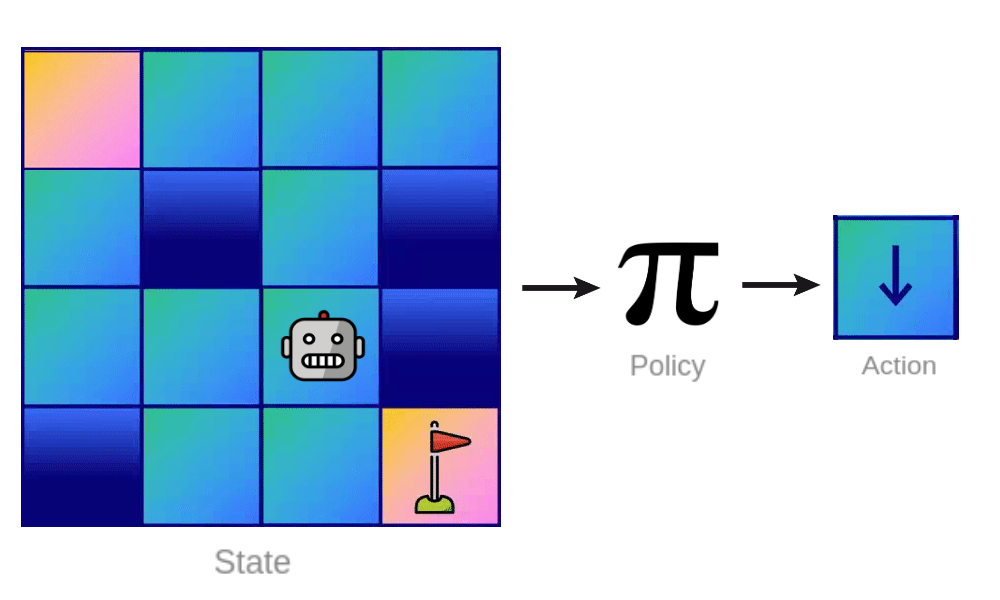

##### **Policy Type: Deterministic or Stochastic?**

  - Deterministic Policy üîç: is a mapping œÄ: S -> A.
      
       ‚Üí The agent always selects a single action with certainty for each state.
  - Stochastic Policy üé≤: is a mapping œÄ: S x A -> [0,1]  œÄ(s|a) = P(At=a| St = s)
       
       ‚Üí The policy assigns probabilities to different actions

##### **Exercise 1.2 Code Task: Have fun coding your policy and observing it in action! üéÆüèûÔ∏è**

In the following image, we have a deterministic policy. Your task is to fill `...` in the code cell provided below to create a policy that matches the actions shown in the image.


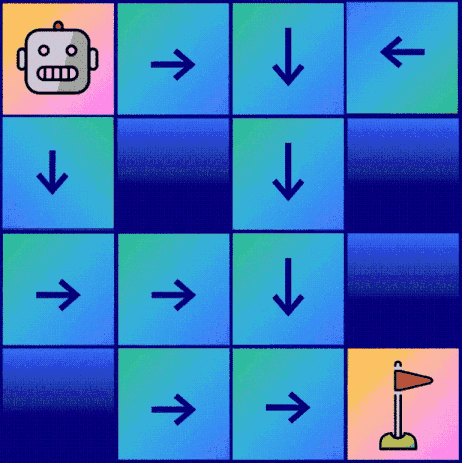

<h5><details>
  <summary>üîΩ <b>Click here to unveil hints!</b> üîΩ</summary>
  
  1. Seek inspiration from the code demonstrated in the previous section related to "understanding the Agent-Environment Interaction"!

  2. A policy functions as a map that connects a state to a corresponding action. In this context, the policy dictionary we possess contains state values ranging from 0 to 15 as keys, each linked to a specific action value.
  
  3. The image doesn't depict any action for the holes, and you're free to assign any action to them or just ignore them. These holes are essentially non-navigable since the agent, unfortunately, meets their demise upon entering them üòµ.
    
</details></h5>


In [ ]:
# @title Solution

import gymnasium as gym
Action =["LEFT", "DOWN", "RIGHT", "UP"] # 0: Left 1:Down 2:Right 3:Up
env = gym.make("FrozenLake-v1",render_mode="rgb_array", is_slippery=False)
env = gym.wrappers.RecordVideo(env, 'video', episode_trigger = lambda x: x == 0)

# üéØ Define the Heroic Policy:
policy ={
    0: 2,
    1: 2,
    2: 1,
    3: 0,
    4: 1,
    5: 0,
    6: 1,
    7: 0,
    8: 2,
    9: 2,
    10: 1,
    11: 1,
    12: 0,
    13: 2,
    14: 2,
    15: 0
}

state, info = env.reset(seed=42)
timestep=0
terminated, truncated= False, False
while not (terminated or truncated):
    print("Timestep: ",timestep)

    # Chose the action based on the policy!
    action = policy[state]

    # Step the environment.
    state, reward, terminated, truncated, info = env.step(action)

    done = terminated or truncated

    print("\tObservation (position):", init_state)
    print(f"\tAction: {Action[action]} ({action})")
    print("\tNew observation (position):", new_state)
    print("\tReward:", reward)
    print("\tGame is done:", done)

    # Increment timestep
    timestep+=1

env.close()

In [ ]:
# @title  The rendering of the solution

from IPython.display import HTML
from base64 import b64encode

path="/content/video/rl-video-episode-0.mp4"
mp4 = open(path,'rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

##### **Optimal Policy $œÄ^*$ : Finding the Coolest Route Across Thin Ice!**

Changing the code above gives us the power to create multiple policies that can reach the goal:

Option 1:

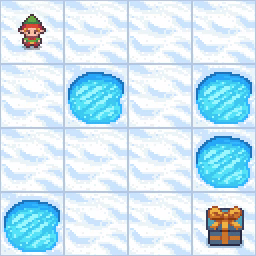

Option 2:

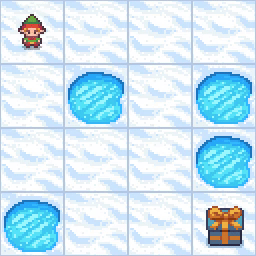

Option 3:

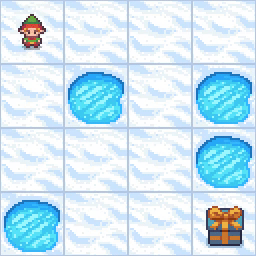

Now, the key question arises: among these choices, How to compare these policies and which of them should the agent follow for the best outcome?

**üèÜ Optimal policy**

An optimal policy is like the smartest plan in a game. It's the strategy that gives you the highest rewards. To compare policies, you see which one gets you more rewards overall. It's like finding the best way to win! üéÆüèÜ

**üïµ In depth <font color='orange'>`Intermediate`</font>**

As we previously established the agent's objective is to obtain the highest possible reward. Accordingly, a policy denoted as $œÄ$ is considered superior to or on par with another policy $œÄ'$ if the anticipated cumulative reward it yields surpasses or equals that of policy $œÄ'$ across all possible states.

In light of this, an optimal policy is a policy that when followed, will yield the best possible return in the environment. This optimal policy, giving by $œÄ^*$, can be loosely expressed mathematically as:        $$œÄ^* = \max \mathbb{E}_{\pi} [G]$$



####State Value Function




 **üìö Core Idea**

 The state value function, often denoted as $V_{\pi}(s)$, is defined as the expected cumulative reward an agent can obtain while starting from a specific state $\mathcal{s}$ and following a certain policy œÄ. In other words,$V_{\pi}(s)$  estimates the long-term return an agent can achieve from a given state by considering the expected sum of future rewards, accounting for the policy's influence on the agent's actions.

**üßô‚Äç‚ôÇÔ∏è Understanding the State Value Function in FrozenLake**

Think of the state value function as your crystal ball for success. It's like a fortune teller that helps you predict how awesome each spot is on the frozen lake.
The state-value function, or let's call it $V_{\pi}(s)$, tells you how good each spot is. It spills the beans on the rewards you'll scoop up if you start there and stick to your plan from there on out.



######**ü§ì The Mathematical Definition <font color='orange'>`Intermediate`</font>**

The mathematical formula for the state-value function is given by:

$$ V_{\pi}(s) = \mathbb{E}_{\pi} \left[ \sum_{t=0}^{\infty} \gamma^t R_{t+1} \mid S_0 = s \right] $$

or it can be expressed this way as:

$$ {V_{\pi}(s)} = \mathbb{E}_{\pi} \left[ G_t = R_{t} + \gamma R_{t+1} + \gamma^{2} R_{t+2} + \dots | S_t = s \right] $$

Where:
 - $V_{\pi}(s)$ represents the state-value of state $s$ under policy $\pi$.
 - $\mathbb{E}_{\pi}$ denotes the expectation operator with respect to the policy $\pi$.
 - $\gamma$ is the discount factor, which determines the importance of future rewards.
 - $G_t$ represents the cumulative discounted future reward starting from time step $t$.
 - $S_t = s$ indicates that the agent at state $s$ at the timestep $t$.

**Exercise 1.3 Code Task**

In this code task, we're connecting with the mathematical expression of the state value function. We want to compute the cumulative return using given rewards and a discount value, which helps us understand long-term rewards.

The rewards array contains rewards at different time steps. By applying discounting, we consider how much we value future rewards relative to immediate ones. The goal is to complete the compute_discounted_return function to calculate the cumulative return using the provided formula.

#### 2.3.2 Selecting actions with a q-table <font color='blue'>`Beginner`</font>:

In order for an agent to select and action from the q-values from a current state it has to follow some policy derived from the q-values. The simplest of these strategies is a greedy strategy where an agent selects an action based on the greatest q-value. We can represent this strategy mathematically as
$$ \pi_{\text{greedy}} = \underset{a}{\mathrm{argmax}} \text{ } Q (s, a) $$

#### 2.3.5 The goal of Q-learning - <font color='blue'>`Beginner`</font>

Something to note is the overarching goal of q-learning, which is to learn the optimal q-function so that our agent can derive the best possible policy from it!

##### Group task:

Consider the following two q-tables. One before learning and one after learning. Discuss with a friend what the differences are that you notice between the two and why you think these differences exist.

```
          Q-table before learning                                   Q-table after learning
                              
           Left     Down    Right       Up                           Left     Down    Right       Up
------------------------------------------                ------------------------------------------
 s_0 |   0.0000   0.0000   0.0000   0.0000                 s_0 |   0.1821   0.5905   0.0197   0.1701
 s_1 |   0.0000   0.0000   0.0000   0.0000                 s_1 |   0.1536   0.0000   0.0000   0.0000
 s_2 |   0.0000   0.0000   0.0000   0.0000                 s_2 |   0.0000   0.0000   0.0000   0.0000
 s_3 |   0.0000   0.0000   0.0000   0.0000                 s_3 |   0.0000   0.0000   0.0000   0.0000
 s_4 |   0.0000   0.0000   0.0000   0.0000                 s_4 |   0.2115   0.6561   0.0000   0.1738
 s_5 |   0.0000   0.0000   0.0000   0.0000                 s_5 |   0.0000   0.0000   0.0000   0.0000
 s_6 |   0.0000   0.0000   0.0000   0.0000                 s_6 |   0.0000   0.0000   0.0000   0.0000
 s_7 |   0.0000   0.0000   0.0000   0.0000                 s_7 |   0.0000   0.0000   0.0000   0.0000
 s_8 |   0.0000   0.0000   0.0000   0.0000     ------>     s_8 |   0.2146   0.0000   0.7290   0.1603
 s_9 |   0.0000   0.0000   0.0000   0.0000                 s_9 |   0.1645   0.8100   0.0450   0.0000
s_10 |   0.0000   0.0000   0.0000   0.0000                s_10 |   0.0000   0.3853   0.0000   0.0000
s_11 |   0.0000   0.0000   0.0000   0.0000                s_11 |   0.0000   0.0000   0.0000   0.0000
s_12 |   0.0000   0.0000   0.0000   0.0000                s_12 |   0.0000   0.0000   0.0000   0.0000
s_13 |   0.0000   0.0000   0.0000   0.0000                s_13 |   0.0000   0.0839   0.9000   0.2562
s_14 |   0.0000   0.0000   0.0000   0.0000                s_14 |   0.1501   0.2965   1.0000   0.0435
s_15 |   0.0000   0.0000   0.0000   0.0000                s_15 |   0.0000   0.0000   0.0000   0.0000


```

#### 2.3.6 Playing Frozen Lake with Q-learning <font color='blue'>`Beginner`</font>

Recall that when using random policy search, our agent was not able to ever reach the goal state in frozen lake. Let's see whether our agent can do any better with q-learning:

In [ ]:
# Intialise our q-table
q_table = jnp.zeros((observation_space_shape, action_space_shape))

print(f"Q-TABLE BEFORE TRAINING: \n")
print_q_table(q_table, True)

In [ ]:
# Specify q-learning hyperparameters
NUM_EPISODES = 1000
LEARNING_RATE = 0.05
GAMMA = 0.9

# Lists to keep track of q-values and state values for rendering later on.
q_values = []
state_values = []

# Agent training loop.
for i in notebook.tnrange(NUM_EPISODES, desc="TRAINING EPISODES"):
  # Reset the environment
  state, info = env.reset()
  done = False
  # Inner environment loop
  while not done:

    # Select action using our current q-table
    if jnp.max(q_table[state]) > 0.0:
      action = greedy_action_selection(q_table[state])
    else:
      action = env.action_space.sample()

    # Step the environment.
    new_state, reward, terminated, truncated, info = env.step(int(action))

    # q-learning update rule
    td_target = reward + GAMMA * jnp.max(q_table[new_state]) - q_table[state, action]
    new_q_value = q_table[state, action] + LEARNING_RATE * td_target
    q_table = q_table.at[state, action].set(new_q_value)

    # Check whether the episode has termination
    done = terminated or truncated
    # Replace current state with next state to continue training
    state = new_state

  state_values.append(jnp.mean(q_table, axis=1).reshape(4, 4))
  q_values.append(jnp.copy(q_table).reshape(4, 4, 4))

print(f"Q-TABLE AFTER TRAINING: \n")
print_q_table(q_table, True)

Let's have a look to see how our agent's state values and state-action values got updated during training.

In [ ]:
display_state_values_as_gif(state_values[::10], 300)

In [ ]:
display_q_values_as_gif(q_values[::10], 300)

#### 2.3.7 Exploration vs Exploitation - <font color='blue'>`Beginner`</font>

At the moment our agent is acting completely greedily. Meaning that, at each environment timestep, it will always take the action that it believes to be the best. This works well in a simple task, like frozen lake, where the agent can stumble upon the correct behaviour relatively quickly. But this isn't necessarily the case for more complex tasks. Let's consider an example:

Suppose you really love coffee and you have recently moved to a new town. On your first morning you decide to go looking for a coffee shop and, after walking a block or so, you find one. You go inside and get a coffee to satisfy your caffiene craving and the cofee is okay, but definitely not as good as your hometown! The next day, you have one of two options, either you can go wandering around town in search of a new coffee shop (although you might not find one in time and be late for work) or you could go back to the one you found yesterday where at least you will get some coffee! This is exactly the exploration-exploitation trade-off in reinforcement learning.

If an agent finds a state that will give it some reward it can over-optimise for those rewards and never explore different states that could have greater rewards! This is equivalent to you never finding the coffee shop four blocks from your new house that recently got voted the best in the world while always drinking the average coffee you found on day 1.

**Group Task:**

Discuss with someone close to you how you think we could incentivise an RL agent to explore new states it hasn't seen before.

#### 2.3.8 Epsilon-greedy policies - <font color='orange'>`Intermediate`</font>

Effective exploration in RL is actually an ongoing area of research, but a common exploration strategy that is used is referred to as epsilon-greedy. Here some parameter $\epsilon$ is chosen which is a value on the interval $[0, 1]$. At each timestep our agent will then select a random action with probability $\epsilon$ and act greedily with probability $1 - \epsilon$.

##### Exercise 2.3.8

Let's implement an epsilon-greedy action selection function:

In [ ]:
def epsilon_greedy_action_selection(q_values, epsilon, key, num_actions=4):
  key, epsilon_key = jax.random.split(key)
  take_random_action = ... # A boolean value. The agent will act randomly if true.

  if take_random_action:
    key, action_key = jax.random.split(key)
    action = .... # Act randomly

  else:
    action = ... # Act greedily

  return action

In [ ]:
# @title Answer to code task (Try not to peek until you've given it a good try!')

def epsilon_greedy_action_selection(q_values, epsilon, key, num_actions=4):

  key, epsilon_key = jax.random.split(key)
  take_random_action = jax.random.uniform(key=epsilon_key, shape=()) < epsilon

  if take_random_action:
    key, action_key = jax.random.split(key)
    action = jax.random.randint(key=action_key, minval=0, maxval=num_actions, shape=())

  else:
    action = greedy_action_selection(q_values)

  return action

##### Training an agent with an epsilon-greedy policy
Let's train an agent with a epsilon-greedy policy this time.

In [ ]:
# Intialise our q-table
q_table = jnp.zeros((observation_space_shape, action_space_shape))

print(f"Q-TABLE BEFORE TRAINING: \n")
print_q_table(q_table, True)

In [ ]:
NUM_EPISODES = 1000
LEARNING_RATE = 0.05
GAMMA = 0.9
EPSILON = 0.4

key = jax.random.PRNGKey(44)

q_values = []
state_values = []

for i in notebook.tnrange(NUM_EPISODES, desc="TRAINING EPISODES"):
  # Reset the environment
  state, info = env.reset()
  done = False
  while not done:

    if jnp.max(q_table[state]) > 0.0:
      key, take_action_key = jax.random.split(key)
      action = epsilon_greedy_action_selection(
          q_values=q_table[state],
          epsilon=EPSILON,
          key=take_action_key,
      )
    else:
      action = env.action_space.sample()

    # Step the environment.
    new_state, reward, terminated, truncated, info = env.step(int(action))

    td_target = reward + GAMMA * jnp.max(q_table[new_state]) - q_table[state, action]
    new_q_value = q_table[state, action] + LEARNING_RATE * td_target
    q_table = q_table.at[state, action].set(new_q_value)

    done = terminated or truncated
    state = new_state

  state_values.append(jnp.mean(q_table, axis=1).reshape(4, 4))
  q_values.append(jnp.copy(q_table).reshape(4, 4, 4))

print(f"Q-TABLE AFTER TRAINING: \n")
print_q_table(q_table, True)

In [ ]:
display_state_values_as_gif(state_values[::10], 200)

In [ ]:
display_q_values_as_gif(q_values[::10], 200)

##### **Group Task:**


Discuss with someone close to you any differences you notice between the q-values, state value and trained q-table of the fully greedy policy and the epsilon-greedy policy. Why do you think these differences exist?

#### 2.3.9 Epsilon decay schedules - <font color='green'>`Advanced`</font>

The naive epsilon-greedy schedule we considered previously keeps the value of $\epsilon$ fixed over the entire time the agent is trained. This might not always be an optimal solution since we do not always want our agent to explore but to start exploiting its knowledge of the environment more as it has learnt. An example in frozen lake would be that we do not want the agent to randomly select an action that could make it fall into a hole when it has already learnt where all the holes are!

A way to allow our agent to exploit its knowledge of the environment more over time is to use a schedule that decays our epsilon value as training progresses. This would mean that our epsilon value starts out high (usually at 1) and then decreases to a smaller value. This small value could be 0, but in practice is some small non-zero value, like 0.05, to allow our agent to still explore a little bit later on it training.

##### Exercise 2.3.9
Many of these schedules exist, but the simplest version is to use a linearly decaying epsilon scheduler.

Let's code one up! Hint: think straight line equation here!

In [ ]:
def linear_epsilon_schedule(step_count, starting_epsilon, ending_epsilon):

  slope = ...
  epsilon = ...

  # Make sure that the epsilon value can never decrease below `ending_epsilon`
  epsilon = jnp.maximum(...)

  return epsilon

In [ ]:
# @title Run me to test your code

def test_linear_epsilon_schedule(epsilon_fn):
  assert epsilon_fn(0) == 1.0, "Still needs a bit of work."
  assert epsilon_fn(2000) == 0.05, "Still needs a bit of work."
  assert epsilon_fn(500) == 0.525, "Still needs a bit of work."
  print("Nice! Your answer looks correct.")

test_linear_epsilon_schedule(linear_epsilon_schedule)

In [ ]:
# @title Answer to code task (Try not to peek until you've given it a good try!')

def linear_epsilon_schedule(step_count, starting_epsilon=1.0, ending_epsilon=0.05, num_decay_steps=1000):

  slope = (starting_epsilon - ending_epsilon) / (0.0 - num_decay_steps)
  epsilon = step_count * slope + starting_epsilon

  # Make sure that the epsilon value can never decrease below `ending_epsilon`
  epsilon = jnp.maximum(ending_epsilon, epsilon)

  return epsilon

test_linear_epsilon_schedule(linear_epsilon_schedule)

##### Training an agent with a decaying epsilon schedule
Let's train an agent with a epsilon-greedy policy with a decaying epsilon this time.

![DQN](https://drive.google.com/uc?export=view&id=1eWcKOAOO9LKlXY5g4IGHA_uacwn5pg4a)

#### **Build your own DQN!**

In [ ]:
# Code adapted from https://github.com/vwxyzjn/cleanrl/blob/master/cleanrl/dqn_jax.py
import flax.linen as nn
import flax
from flax.training.train_state import TrainState
class Q_Network(nn.Module):
    action_dim: int

    @nn.compact
    def __call__(self, x: jnp.ndarray):
        x = nn.Dense(64)(x)
        x = nn.relu(x)
        x = nn.Dense(32)(x)
        x = nn.relu(x)
        x = nn.Dense(self.action_dim)(x)
        return x


class TrainState(TrainState):
    target_params: flax.core.FrozenDict


def linear_schedule(start_e: float, end_e: float, duration: int, t: int):
    slope = (end_e - start_e) / duration
    return max(slope * t + start_e, end_e)

In [ ]:
@jax.jit
def update(q_state, observations, actions, next_observations, rewards, dones):
    q_next_target = q_network.apply(q_state.target_params, next_observations)  # (batch_size, num_actions)
    q_next_target = jnp.max(q_next_target, axis=-1)  # (batch_size,)
    next_q_value = rewards + (1 - dones) * gamma * q_next_target

    def mse_loss(params):
        q_pred = q_network.apply(params, observations)  # (batch_size, num_actions)
        q_pred = q_pred[jnp.arange(q_pred.shape[0]), actions.squeeze()]  # (batch_size,)
        return ((q_pred - next_q_value) ** 2).mean(), q_pred

    (loss_value, q_pred), grads = jax.value_and_grad(mse_loss, has_aux=True)(q_state.params)
    q_state = q_state.apply_gradients(grads=grads)
    return loss_value, q_pred, q_state

In [ ]:
import random
import optax
from stable_baselines3.common.buffers import ReplayBuffer

NUM_EPISODES = 2000
LEARNING_RATE = 0.05
GAMMA = 0.9
EPSILON = 0.4

start_epsilon = 1
end_epsilon = 0.05
exploration_fraction=0.5

seed=42

key = jax.random.PRNGKey(44)

seed = 42
learning_rate=2.5e-4
rewards_all_episodes = []

q_values = []
state_values = []

training_step = 0
max_steps_per_episode= 200

buffer_size = 10000
total_timesteps=5000000

learning_starts=10000
train_frequency=10
batch_size=128


target_network_frequency=500

gamma=0.99
tau=1

# env setup
env = gym.make('FrozenLake-v1', desc=None, map_name="8x8", is_slippery=False, render_mode="rgb_array")
env = gym.wrappers.RecordVideo(env, 'video', episode_trigger = lambda x: x%100 == 0)

rb = ReplayBuffer(
    buffer_size,
    env.observation_space,
    env.action_space,
    "cpu",
    handle_timeout_termination=False,
)

random.seed(seed)
np.random.seed(seed)
key = jax.random.PRNGKey(seed)
key, q_key = jax.random.split(key, 2)

obs, _ = env.reset(seed=seed)
obs = jnp.array([obs])

q_network = Q_Network(action_dim=env.action_space.n)

q_state = TrainState.create(
    apply_fn=q_network.apply,
    params=q_network.init(q_key, obs),
    target_params=q_network.init(q_key, obs),
    tx=optax.adam(learning_rate=learning_rate),
)

q_network.apply = jax.jit(q_network.apply)
# This step is not necessary as init called on same observation and key will always lead to same initializations
q_state = q_state.replace(target_params=optax.incremental_update(q_state.params, q_state.target_params, 1))


random.seed(seed)

for i in notebook.tnrange(NUM_EPISODES, desc="TRAINING EPISODES"):
  # Reset the environment
  state, info = env.reset()
  done = False
  # while not done:
  for step in range(max_steps_per_episode):

    epsilon = linear_schedule(start_epsilon, end_epsilon, exploration_fraction * total_timesteps, training_step)
    if random.random() < epsilon:
        action = env.action_space.sample()
    else:
        q_values = q_network.apply(q_state.params, obs)
        actions = q_values.argmax(axis=-1)
        actions = jax.device_get(actions)

        action = np.int64(actions.item())

    # Step the environment.
    new_state, reward, terminated, truncated, info = env.step(int(action))

    state = jnp.array([state])
    new_state = jnp.array([new_state])
    rb.add(state, new_state, action, reward, terminated, info)

    training_step += 1

    # ALGO LOGIC: training.
    if training_step > learning_starts:
        if training_step % train_frequency == 0:
            data = rb.sample(batch_size)
            # perform a gradient-descent step
            loss, old_val, q_state = update(
                q_state,
                data.observations.numpy(),
                data.actions.numpy(),
                data.next_observations.numpy(),
                data.rewards.flatten().numpy(),
                data.dones.flatten().numpy(),
            )


        # update target network
        if training_step % target_network_frequency == 0:
            q_state = q_state.replace(
                target_params=optax.incremental_update(q_state.params, q_state.target_params, tau)
            )

    done = terminated or truncated
    state = new_state


## Beyond Discrete Actions - Policy Gradient Methods (Homework)

We have only covered a very limited set of reinforcement learning methods. If you would like to learn about a whole other family of techniques (on which current state of the art methods are based) please have a look at the practical from 2022 [here](https://colab.research.google.com/github/deep-learning-indaba/indaba-pracs-2022/blob/main/practicals/introduction_to_reinforcement_learning.ipynb).

## Conclusion
**Summary:**

In this practical, we learned about the basics of reinforcement learning (RL). We worked on the intuition behind RL and also learned the basic concepts, terminology and formalism required for RL. We introduced some forms of learning in RL, such as Monte-Carlo and Temporal Difference methods. Finally, we learned how to implement tabular Q-learning and were introduced to Deep Q-Networks (DQN), one of the first breakthroughs in Deep RL.




**References:**

- [Reinforcement Learning: An Introduction](http://incompleteideas.net/book/the-book-2nd.html)